In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [25]:
import datetime as dt
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [43]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct, desc

In [44]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [45]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [46]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [47]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [48]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

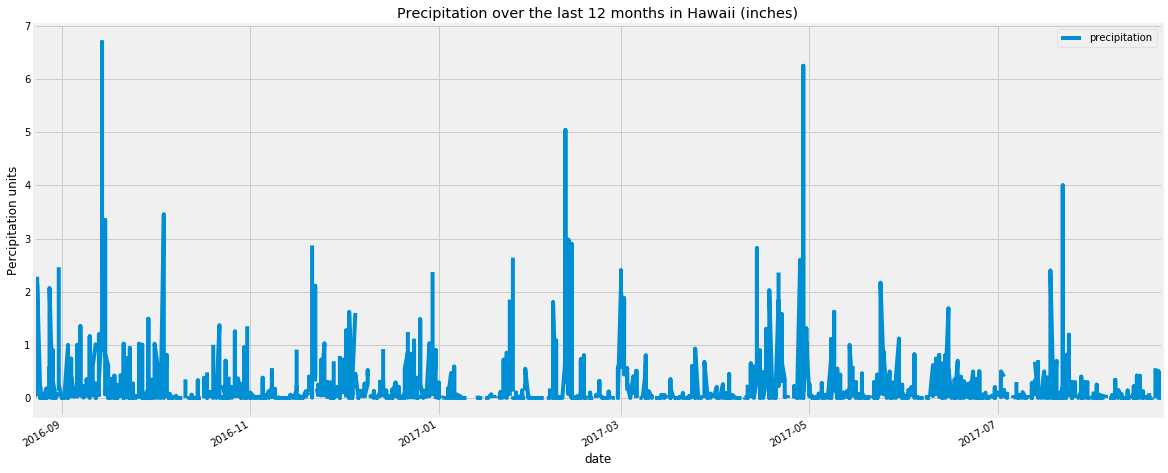

In [49]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
yearago = session.query(
    Measurement.id,
    Measurement.station,
    Measurement.date,
    Measurement.prcp,
    Measurement.tobs)\
.filter(Measurement.date.between('2016-08-23','2017-08-23')).order_by(Measurement.id.asc()).all()

# Perform a query to retrieve the data and precipitation scores
results_py = [r for r in yearago]
results_py

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(yearago, columns = ['id','station','date','precipitation','tobs'])
df.date = pd.to_datetime(df.date)
df_indexed = df.set_index('date')

# Sort the dataframe by date
sorted_df = df_indexed.sort_index()
sorted_df

# Use Pandas Plotting with Matplotlib to plot the data

fig1, ax1 = plt.subplots()
sorted_df.precipitation.plot(kind='line', 
                               ax=ax1,
                               figsize = (18,8),
                               grid = True,
                               legend = True,
                               title = 'Precipitation over the last 12 months in Hawaii (inches)'
)
ax1.set_ylabel('Percipitation units')
fig1.savefig('Precipitation_results.png')


In [50]:
# Use Pandas to calcualte the summary statistics for the precipitation data

sorted_df.precipitation.describe()


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

In [51]:
# Design a query to show how many stations are available in this dataset?

station_results = session.query(func.count(func.distinct(Measurement.station))).order_by(Measurement.station).all()
station_results

[(9)]

In [56]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_results = session.query(func.distinct(Measurement.station),
                          func.count(Measurement.station)
                         ).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()

station_results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [65]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_station = station_results[0][0]
print(f'{top_station}')

high_results = session.query(
        func.count(Measurement.station),
        func.round(func.avg(Measurement.tobs),2),
        func.min(Measurement.tobs),
        func.max(Measurement.tobs)
).filter(Measurement.station == top_station).all()
pprint(high_results)

USC00519281
[(2772, 71.66, 54.0, 85.0)]


In [69]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
obs_results = session.query(
        Measurement.station,
        Measurement.tobs,
        Measurement.date
).filter(Measurement.station == top_station).filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()

#pprint(obs_results)

![precipitation](Images/station-histogram.png)

In [71]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [72]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start = '2017-01-01'
end = '2017-12-31'
stat = calc_temps(start,end)
print(f'''
Tempterature range between the dates {start} and {end}.
{stat}
''')


Tempterature range between the dates 2017-01-01 and 2017-12-31.
[(58.0, 74.14387974230493, 87.0)]



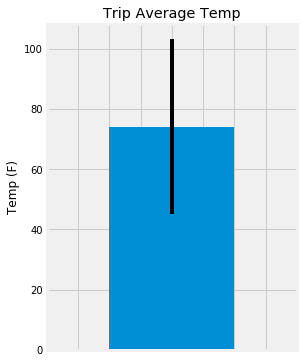

In [75]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig3, ax3 = plt.subplots(figsize=(4,6))

min_stat = stat[0][0]
avg_stat = stat[0][1]
max_stat = stat[0][2]

y_error_stat = max_stat - min_stat

ax3.bar(x=0,height=[avg_stat],width=0.1,yerr = y_error_stat);
ax3.set_xlim(xmin= -0.1, xmax=0.1);
ax3.set_xticklabels([]);
ax3.set_ylabel('Temp (F)');
ax3.set_title('Trip Average Temp');
fig3.savefig('Trip_Average_Temperature.png');


In [76]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain_result = session.query(
    Station.station,
    Station.latitude,
    Station.longitude,
    Station.elevation,
    func.round(func.sum(Measurement.prcp),2)
)\
.filter(Station.station == Measurement.station)\
.filter(Measurement.date.between('2016-08-23', '2017-08-23'))\
.group_by(Station.station)\
.order_by(desc(func.round(func.sum(Measurement.prcp),2))).all()

rain_result

[('USC00516128', 21.3331, -157.8025, 152.4, 147.81),
 ('USC00519281', 21.45167, -157.84888999999998, 32.9, 70.03),
 ('USC00513117', 21.4234, -157.8015, 14.6, 48.51),
 ('USC00519523', 21.33556, -157.71139, 19.5, 38.01),
 ('USC00514830', 21.5213, -157.8374, 7.0, 33.24),
 ('USC00519397', 21.2716, -157.8168, 3.0, 16.09),
 ('USC00517948', 21.3934, -157.9751, 11.9, 4.59)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


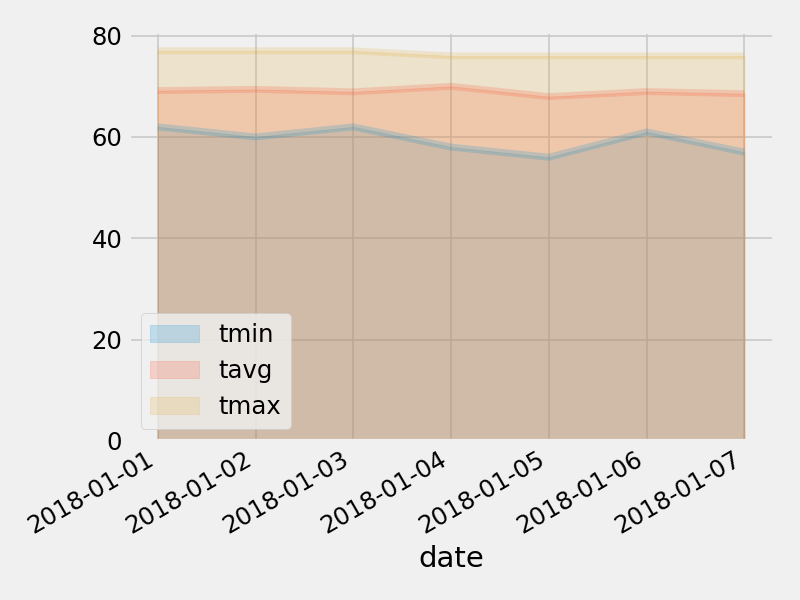

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
